In [734]:
import numpy as np
import torch
import pandas as pd
from sklearn import metrics
from matplotlib import pyplot as plt
from tqdm import tqdm
import math
import scipy
import random
import os
import libsvm
from libsvm import commonutil
from sklearn.linear_model import LinearRegression, Ridge
array = np.array
scipy.array = np.array

In [735]:
def qq(y):
    if y.shape[-1] == 1:
        return list(y.reshape(y.shape[:-1]))
    return list(y)

In [736]:
seed = 1723

random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

eps = 5e-5
tol = eps

In [737]:
def getMatrixLmuW(W):
    vals = np.real_if_close(scipy.linalg.eigvals(W.T @ W), tol=eps)
    LW = np.max(vals)
    muW = np.min(vals[vals > eps])
    return np.real_if_close(LW, tol=eps).item(), np.real_if_close(muW, tol=eps).item()

In [738]:
def getMatrixLmuA(Ai):
    LA = max(np.max(np.real_if_close(scipy.linalg.eigvals(mat.T @ mat))) for mat in Ai)
    S = Ai[0] @ Ai[0].T
    for i in range(1, len(Ai)):
        S += Ai[i] @ Ai[i].T
    S /= n
    eigens = np.linalg.eigvals(S)
    muA = np.min(eigens[eigens > eps])
    return np.real_if_close(LA, tol=eps).item(), np.real_if_close(muA, tol=eps).item()

In [739]:
def mulWp(y):
    rho = (np.sqrt(LW) - np.sqrt(muW))**2 / 16
    v = (np.sqrt(LW) + np.sqrt(muW)) / 2
    d = -v/2
    n = int(np.ceil(kW) + 0.5)
    p = - W @ y / v
    yi = y + p
    for i in range(1, n):    
        beta = rho/d
        d = -(v+beta)
        p = (W @ yi + beta * p) / d
        yi = yi + p
    return y - yi

In [740]:
def grad_G(u):
    assert dimx + dimy == u.shape[0]
    x, y = u[:dimx, :], u[dimx:, :]
    z = r * (A @ x + gamma * mulWp(y) - b)
    grad = grad_F(x)
    ans = np.concatenate((grad + A.T @ z, gamma * mulWp(z)))
    return ans

In [741]:
def K_Chebyshev(u):
    assert dimx + dimy == u.shape[0]
    x, y = u[:dimx, :].copy(), u[dimx:, :].copy()
    rho = (LB - muB)**2 / 16
    v = (LB + muB) / 2
    d = -v/2
    n = int(np.ceil(kB) + 0.5)
    q = A @ x + gamma * mulWp(y) - b
    p = (-1/v) * np.concatenate((A.T @ q, gamma * mulWp(q)))
    ui = u + p
    for i in range(1, n):
        beta = rho/d
        d = -(v + beta)
        x, y = ui[:dimx, :].copy(), ui[dimx:, :].copy()
        q = A @ x + gamma * mulWp(y) - b
        p = (1/d) * np.concatenate((A.T @ q, gamma * mulWp(q))) + beta * p / d
        ui = ui + p
    return u - ui   

In [742]:
def sampleLmu(f, d, k=1000000):
    L = 0
    mu = np.inf
    for i in range(1, k+1):
        x1 = torch.normal(mean=0, std =i / np.sqrt(k), size=(d,1))
        x2 = x1 + torch.normal( mean=0,std=0.1, size=(d,1))
        with torch.enable_grad():
            x1.requires_grad_()
            x2.requires_grad_()
            fx1 = f(x1)
            fx1.backward()
            grad = x1.grad[:, 0]
        val = f(x2) - fx1 - torch.dot(grad, x2[:, 0] - x1[:, 0])
        cf = 2 / ((x2 - x1) ** 2).sum()
        mu = min(mu, (val * cf).item())
        L = max(L, (val * cf).item())
    return L + eps, max(eps, mu - eps)

In [743]:
def decomp(x):
    try:
        g = [decomp(y) for y in x]
    except Exception as e:
        return 1
    if all(x == g[0] for x in g):
        return (len(g), g[0])
    return g

In [744]:
torch.set_grad_enabled(False)

In [745]:
LIMIT = 100

In [746]:
data = commonutil.svm_read_problem('./mushrooms.txt', return_scipy=True)
l = 2 * torch.tensor(data[0][:LIMIT], requires_grad=True) - 3
feats = data[1][:LIMIT].toarray()

In [747]:
feats.shape

(100, 112)

In [748]:
n = 7
m, d_feat = feats.shape

In [749]:
x_sep = np.int64(np.round(np.linspace(0, d_feat, n + 1)))
x_sz = np.array([x_sep[i + 1] - x_sep[i] for i in range(n)])
x_sep, x_sz

(array([  0,  16,  32,  48,  64,  80,  96, 112]),
 array([16, 16, 16, 16, 16, 16, 16]))

In [750]:
Fi = [feats[:, x_sep[i]:x_sep[i+1]] for i in range(n)]
Fi[0].shape

(100, 16)

In [751]:
Ai = [np.concatenate((Fi[0], -np.eye(m)), axis=1)] + Fi[1:]

In [752]:
# We waste compute like we're millionaires :)
A = scipy.linalg.block_diag(*Ai)

In [753]:
dimy = m * n
dimz = m
d = d_feat + dimz
dimx = d

In [754]:
def reg_loss(x):
    return (x ** 2).sum() * lmbd

In [755]:
def label_loss(x):
    assert x.shape == l.shape
    return ((x - l)**2).sum() / 2

In [756]:
def lazy_label_loss(x):
    loss = label_loss(x[x_sep[1]:x_sep[1] + dimz, 0])
    return loss

In [757]:
def F(x):
    reg = reg_loss(x[:x_sep[1], :] ** 2) + reg_loss(x[x_sep[1] + dimz:, :] ** 2)
    loss = lazy_label_loss(x)
    return reg + loss

In [758]:
def grad_F(x):
    with torch.enable_grad():
        x = torch.Tensor(x)
        x.requires_grad_()
        reg = lmbd * ((x[:x_sep[1], :] ** 2).sum() + (x[x_sep[1] + dimz:, :] ** 2).sum())
        # print(f'grad_F: z={x[x_sep[1]:x_sep[1] + dimz]}, l={l}')
        
        loss = ((x[x_sep[1]:x_sep[1] + dimz, 0] - l.detach())**2).sum() / 2
        g1 = torch.autograd.grad(reg, x)[0]
        g2 = torch.autograd.grad(loss, x)[0]
        # print(f'grads: reg={g1}, loss={g2}')
        return g1 + g2

In [759]:
L = 2 * np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1)
L[0, -1], L[-1, 0] = -1, -1
print(L)

[[ 2. -1.  0.  0.  0.  0. -1.]
 [-1.  2. -1.  0.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.  0.]
 [ 0.  0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0.  0. -1.  2. -1.]
 [-1.  0.  0.  0.  0. -1.  2.]]


In [760]:
# We waste compute like we're millionaires :) x2
W = np.kron(L, np.eye(m))
W_small = L.copy()

In [761]:
# Unused

def PositiveLeftRoot(t):
    t = np.matrix(t)
    n = t.shape[0]
    c1, piv, rank, info = scipy.linalg.lapack.dpstrf(t)
    c1 = np.triu(c1)
    c1[rank:, :] = 0
    
    P = np.zeros((n, n))
    P[piv-1, np.arange(n)] = 1

    a1 = t
    ww = c1 @ P.T
    return ww

In [762]:
# Unused

def PositiveRightRoot(t):
    t = np.matrix(t)
    n = t.shape[0]
    c1, piv, rank, info = scipy.linalg.lapack.dpstrf(t, lower=1)
    c1 = np.tril(c1)
    c1[:, rank:] = 0
    
    P = np.zeros((n, n))
    P[piv-1, np.arange(n)] = 1


    a1 = t
    ww = P @ c1
    a2 = ww @ ww.T
    return ww

In [763]:
# Unused

def Cpoly(W, l):
    W = np.matrix(W)
    if l == 0:
        return np.eye(W.shape[0])
    if l == 1:
        return W
    return (2 * W) @ (Cpoly(W, l-1)) - Cpoly(W, l-2)

In [764]:
# Unused

def T(l, t):
    return scipy.special.eval_chebyt(l, t)
    # return Cpoly(t, l)
    t = np.matrix(t)
    n = t.shape[0]
    c1 = PositiveLeftRoot(t @ t - 1)
    # c1 = scipy.linalg.sqrtm(t @ t - 1)
    p1 = (t - c1)**l
    p2 = (t + c1)**l
    return (p1 + p2) / 2

In [765]:
# Unused 🐳

def Poly(M, t):
    LM, muM = getMatrixLmuW(M)
    LM, muM = LW ** 0.5, muW ** 0.5
    l = int(np.ceil(np.sqrt(LM / muM)) + 1.5)
    num = T(l, (LM + muM - 2 * t)/(LM - muM))
    denom = T(l, (LM + muM)/(LM - muM))
    return np.real(np.ones(M.shape[0]) - num / denom)

In [766]:
b = np.zeros((LIMIT * n, 1))

In [767]:
def HotAlgorithm2(u, uf, z, mu, theta, alpha, tau, ITERS=10**9):
    with torch.no_grad():
        tqd = tqdm(range(ITERS))
        old_u = u
        for itr in tqd:
            ug = tau * u + (1-tau) * uf
            g = grad_G(ug) - alpha * ug
            ukp12 = 1/(1 + mu * alpha) * (u - mu * (g + z))
            cheb = K_Chebyshev(ukp12)
            zkp = z + theta * cheb
            ukp = 1/(1 + mu * alpha) * (u - mu * (g + zkp))
            # ukp = (u - mu * (g + zkp))
            ufkp = ug + 2 * tau / (2 - tau) * (ukp - u)
            z = zkp
            u = ukp
            uf = ufkp
            tqd.set_description_str(f'u abs diff log_10: {np.round(np.log10(np.sum((old_u - u)**2)), 3)}')
            old_u = u
            yield u, uf, z

In [768]:
def Algorithm2(x, mu, theta, alpha, tau, ITERS=10**9):
    with torch.no_grad():
        y = np.zeros((m * n, 1))
        u = np.concatenate((x, y))
        uf = u.copy()
        z = np.zeros((d + m * n, 1))
        for val in HotAlgorithm2(u, uf, z, mu, theta, alpha, tau, ITERS=ITERS):
            yield val

In [769]:
Wp = mulWp(np.eye(W.shape[0]))

LWp, muWp = (19/15)**2, (11/15)**2

kWp = np.sqrt(LWp / muWp)

In [770]:
Lf, muf = sampleLmu(F, n * m + d, k=15)
muf /= 2
Lf *= 2
Lf, muf = 1, 0.02
kf = np.sqrt(Lf/muf)

In [771]:
#########################
#########################
#########################
#########################

# ALGO

#########################
#########################
#########################
#########################

In [772]:
lmbd = 0.01
Wp = mulWp(np.eye(W.shape[0]))

LWp, muWp = (19/15)**2, (11/15)**2

kWp = np.sqrt(LWp / muWp)

Lf, muf = sampleLmu(F, n * m + d, k=15)
muf /= 2
Lf *= 2
Lf, muf = 1, 0.02
kf = np.sqrt(Lf/muf)

tau = min(1, 1/2 * np.sqrt(19 / (44 * max(1 + kf, 6))))
mu = 1/(4 * tau * max(Lf + muf, 6 * muf))
theta = 15/(19 * mu)
alpha = muf / 4 * 1.01

r = muf / (2 * LA)

LA, muA = getMatrixLmuA(Ai)
kA = np.sqrt(LA/muA)

muB = muA / 2
LB = LA + (LA + muA) * LWp / muWp
kB = np.sqrt(LB/muB)

gamma = np.sqrt((muA + LA) / muWp) # was Wp!

###
L2 = L.copy()
W = np.kron(L2, np.eye(m))
W_small = L2.copy()
LW, muW = getMatrixLmuW(W_small)
kW = np.sqrt(LW/muW)
B = np.concatenate((A, gamma * Wp), axis=1)
###

LW, muW = getMatrixLmuW(W)
kW = np.sqrt(LW/muW)

B = np.concatenate((A, gamma * Wp), axis=1)


x = np.zeros((d,1))
ans = Algorithm2(x, mu, theta, alpha, tau, ITERS=300)
i = 0
pts = []
losses = []
xs = []

for x_val in ans:
    x = x_val[0]
    xoval = x_val
    keffs = np.concatenate((x[:x_sep[1], :], x[x_sep[1] + dimz:-dimy, :]))
    nefk = feats @ keffs
    pts.append(i)
    losses.append(lazy_label_loss(torch.Tensor(x)))
    xs.append(x)
    i += 1

u abs diff log_10: -12.882: 100%|█████████████| 300/300 [01:11<00:00,  4.20it/s]


In [773]:
def mop_plot(a, title='Training Loss'):
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Convert to numpy array for easier manipulation
    steps = np.arange(1, len(a) + 1)
    losses = np.array(a)
    
    # Create figure with two subplots
    plt.figure(figsize=(12, 5))
    
    # Normal scale plot
    plt.subplot(1, 2, 1)
    plt.plot(steps, losses, 'b-', marker='.', label=title)
    plt.xlabel('Step')
    plt.ylabel('Linear scale')
    plt.title(f'{title} (Linear Scale)')
    plt.grid(True)
    plt.legend()
    
    # Log scale plot
    plt.subplot(1, 2, 2)
    plt.semilogy(steps, losses, 'r-', marker='.', label=title)
    plt.xlabel('Step')
    plt.ylabel('Log scale')
    plt.title(f'{title} (Logarithmic Scale)')
    plt.grid(True, which="both", ls="-")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

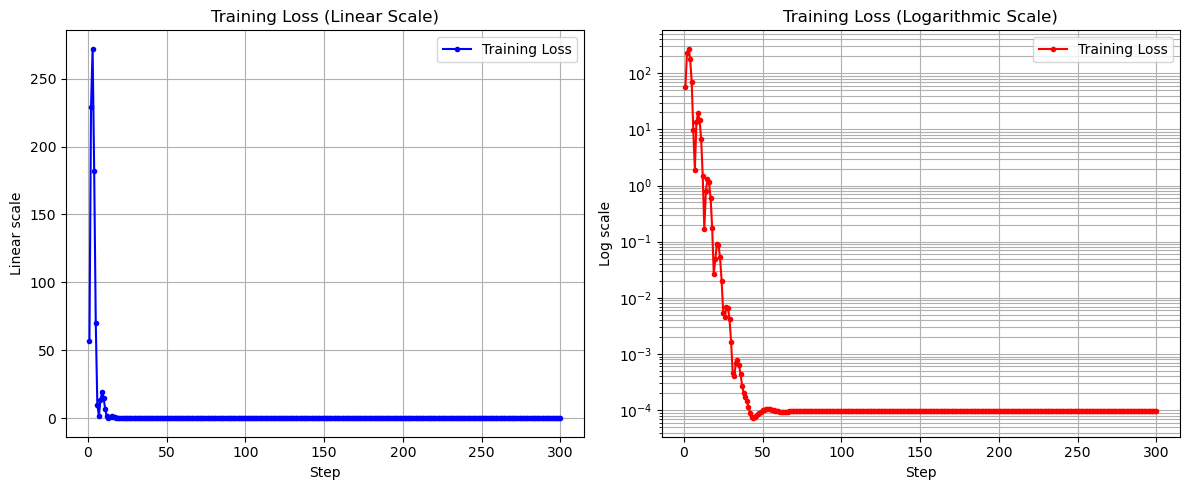

In [774]:
mop_plot(losses)

In [775]:
model = Ridge(alpha=lmbd)
model.fit(feats, l)
preds = model.predict(feats)
vallg10 = np.log10(((preds - l.detach().numpy())**2).sum())
print(f'Ridge: loss 10^({np.round(vallg10, 3)})')

Ridge: loss 10^(-4.302)


In [776]:
ox = np.linalg.inv(feats.T @ feats + 2 * lmbd * np.identity(feats.shape[1])) @ feats.T @ l_numpy

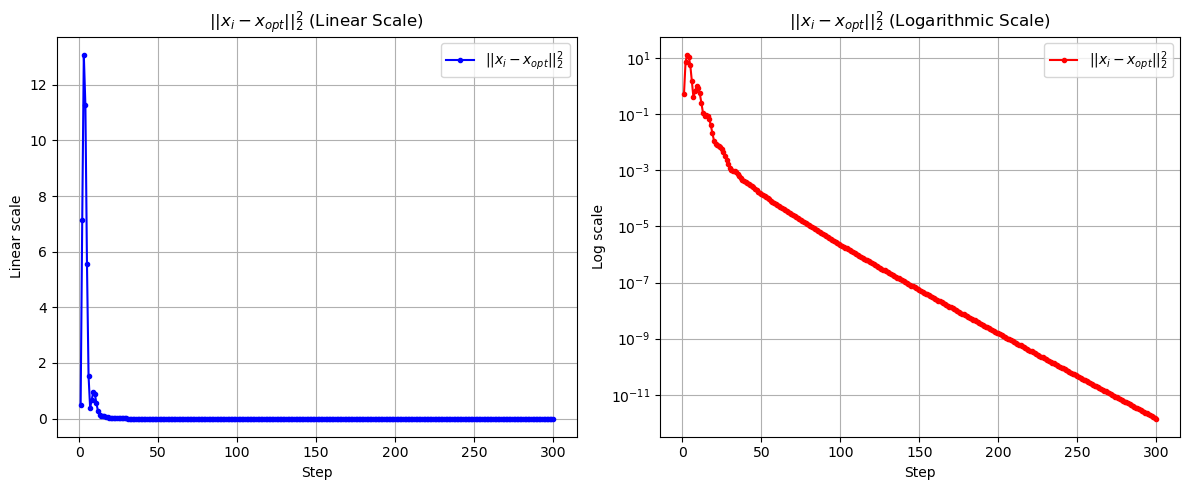

In [777]:
xsn = np.concatenate(xs, axis=1)
xsn = xsn[:dimx]
xsn = np.concatenate((xsn[:x_sep[1]], xsn[x_sep[1]+dimz:]))
dists = ((xsn - np.repeat(ox[:, None], xsn.shape[1], 1))**2).sum(axis=0)
dists[:3]
difloss = dists.flatten()[:300]
mop_plot(difloss, "$||x_i - x_{opt}||_2^2$")

In [778]:
lmbd = 0.01

LWp, muWp = (19/15)**2, (11/15)**2

kWp = np.sqrt(LWp / muWp)

Lf, muf = sampleLmu(F, n * m + d, k=15)
muf /= 2
Lf *= 2
Lf, muf = 1, 0.02
kf = np.sqrt(Lf/muf)

tau = min(1, 1/2 * np.sqrt(19 / (44 * max(1 + kf, 6))))
mu = 1/(4 * tau * max(Lf + muf, 6 * muf))
theta = 15/(19 * mu)
alpha = muf / 4 * 1.01

r = muf / (2 * LA)

LA, muA = getMatrixLmuA(Ai)
kA = np.sqrt(LA/muA)

muB = muA / 2
LB = LA + (LA + muA) * LWp / muWp
kB = np.sqrt(LB/muB)

gamma = np.sqrt((muA + LA) / muWp) # was Wp!

###
L2 = L.copy()
W = np.kron(L2, np.eye(m))
W_small = L2.copy()
LW, muW = getMatrixLmuW(W_small)
kW = np.sqrt(LW/muW)
B = np.concatenate((A, gamma * Wp), axis=1)
Wp = mulWp(np.eye(W.shape[0]))
###

LW, muW = getMatrixLmuW(W)
kW = np.sqrt(LW/muW)

B = np.concatenate((A, gamma * Wp), axis=1)


x = np.zeros((d,1))
ans = Algorithm2(x, mu, theta, alpha, tau, ITERS=300)
i = 0
pts = []
losses = []
xs = []

for x_val in ans:
    x = x_val[0]
    xoval = x_val
    if i in (50, 100, 150, 200):
        idx1 = np.random.randint(0, n)
        idx2 = (idx1 + np.random.randint(2, n-1)) % n
        val = -2 * L2[idx1][idx2] - 1
        L2[idx1][idx2] += val
        L2[idx2][idx1] += val
        L2[idx1][idx1] -= val
        L2[idx2][idx2] -= val
        W = np.kron(L2, np.eye(m))
        W_small = L2.copy()
        LW, muW = getMatrixLmuW(W_small)
        kW = np.sqrt(LW/muW)
        Wp = mulWp(np.eye(W.shape[0]))
        B = np.concatenate((A, gamma * Wp), axis=1)
    keffs = np.concatenate((x[:x_sep[1], :], x[x_sep[1] + dimz:-dimy, :]))
    nefk = feats @ keffs
    pts.append(i)
    losses.append(lazy_label_loss(torch.Tensor(x)))
    xs.append(x)
    i += 1

u abs diff log_10: -12.553: 100%|█████████████| 300/300 [01:15<00:00,  3.95it/s]


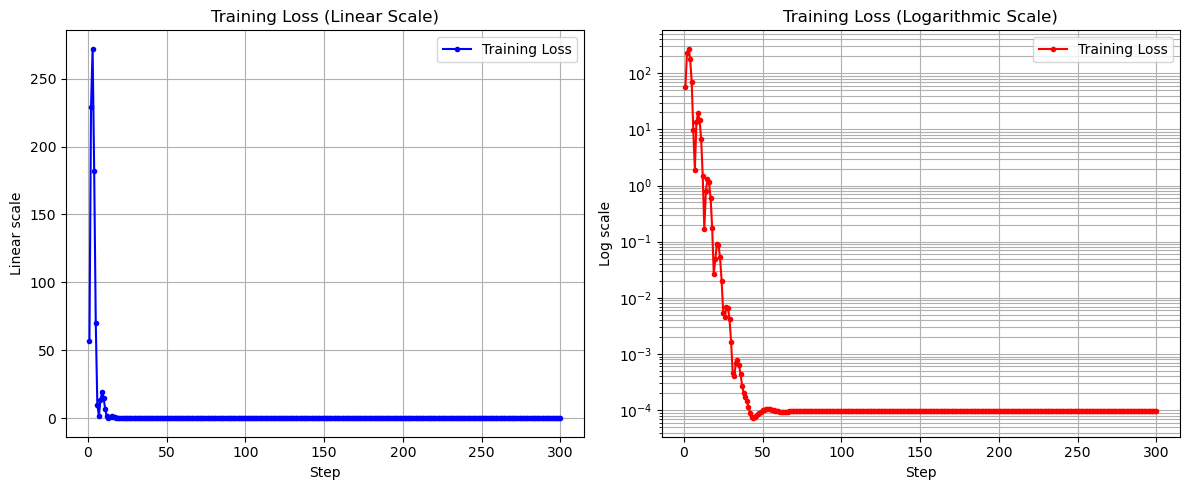

In [779]:
mop_plot(losses)

In [782]:
112/14

8.0

In [780]:
ox = np.linalg.inv(feats.T @ feats + 2 * lmbd * np.identity(feats.shape[1])) @ feats.T @ l_numpy

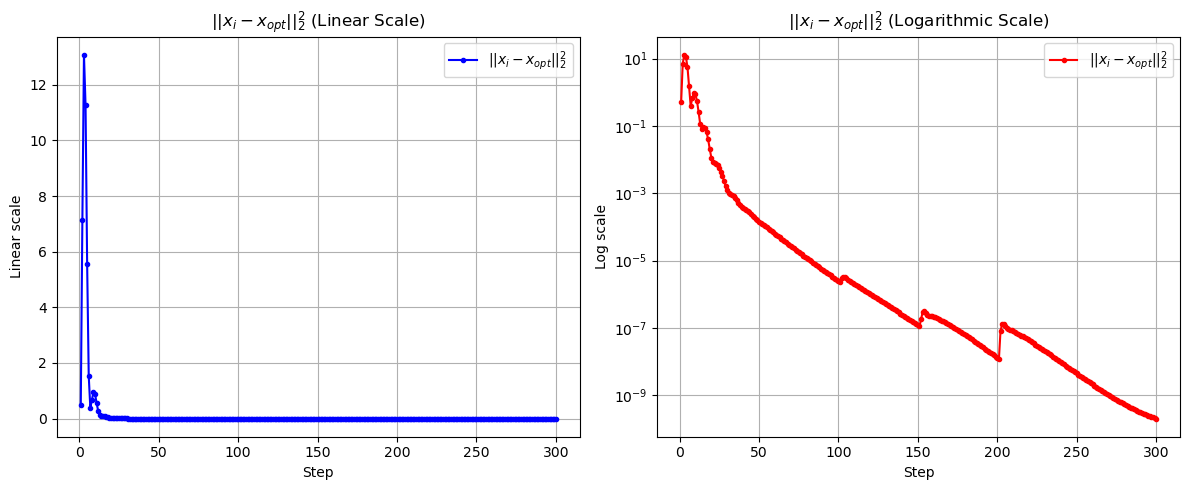

In [781]:
xsn = np.concatenate(xs, axis=1)
xsn = xsn[:dimx]
xsn = np.concatenate((xsn[:x_sep[1]], xsn[x_sep[1]+dimz:]))
dists = ((xsn - np.repeat(ox[:, None], xsn.shape[1], 1))**2).sum(axis=0)
dists[:3]
difloss = dists.flatten()[:300]
mop_plot(difloss, "$||x_i - x_{opt}||_2^2$")